# Projet de Machine Learning 
## Gym Members Exercise Dataset
### EHRHART Elsa, SLISSE Paul, STAUB Guillaume, HOSSEINI Arman
(Notebook R)

In [84]:
library(ggplot2)
library(gridExtra)
library(ranger)
library(dplyr)
library(liver)
library(repr)
library(tidyverse)
library(GGally)
library(e1071)
library(rpart) 
library(rpart.plot)
library(class)
library(caret)
library(plotly)
library(corrplot)
library(FNN)
library(partykit)
library(gplots)
library(statnet)
library(reshape2)
library(olsrr)
library(nlme)
library(FactoMineR) 
library(MASS)
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)

Le chargement a nécessité le package : tergm

Le chargement a nécessité le package : ergm

Error: le chargement du package ou de l'espace de noms a échoué pour 'ergm' in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]) :
le package 'fastmap' 1.1.1 est déjà chargé, mais >= 1.2.0 est requis



ERROR: Error: le package 'ergm' ne peut être chargé


### I. Analyse exploratoire



#### 1.Importation des données

In [2]:
path <- "./gym_members_exercise_tracking.csv"
gym <- read.table(path,sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(gym)
# Vérification du contenu
summary(gym)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

#### 2.Nature, encodage et nettoyage des données

In [3]:
#On change les variables qualitatives en facteur
gym["Gender"]<-as.factor(gym[,"Gender"])
gym["Workout_Type"]<-as.factor(gym[,"Workout_Type"])
gym["Experience_Level"]<-as.factor(gym[,"Experience_Level"])

Les seules variables qualitatives sont $Gender$ et $Workout\_Type$. Nous avons également modifié la variable $Experience\_Level$ en facteur alors que c'est considéré comme une variable quantitative discrète car le nombre de valeurs prises et petites (3) et qu'il nous semble plus judicieux de donner un coefficient pour chaque niveau d'expérience plutôt que pour l'expérience au global. Cela nous permettra également par la suite de plus facilement faire de la classification sur cette variable. Nous avons décidé de conserver la variable $Workout\_Frequency..days.week.$ en quantitative discrète car nous pensons qu'il est plus judicieux de donner un coefficient global pour la variable que pour chaque modalité, le nombre de jour exact étant moins important que la différence de jours entre 2 individus.

In [4]:
# Vérification dans le summary
summary(gym)

      Age           Gender     Weight..kg.       Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   : 40.00   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.: 58.10   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median : 70.00   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   : 73.85   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.: 86.00   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :129.90   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0

In [5]:
find.na(gym)

[1] " No missing values (NA) in the dataset."


Notre jeu de données ne contient aucune valeur manquante, on va pouvoir continuer l'analyse en utilisant l'ensemble du jeu de données.
Nous allons maintenant regarder la distribution des variables.

#### 3.Analyse unidimensionelle

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


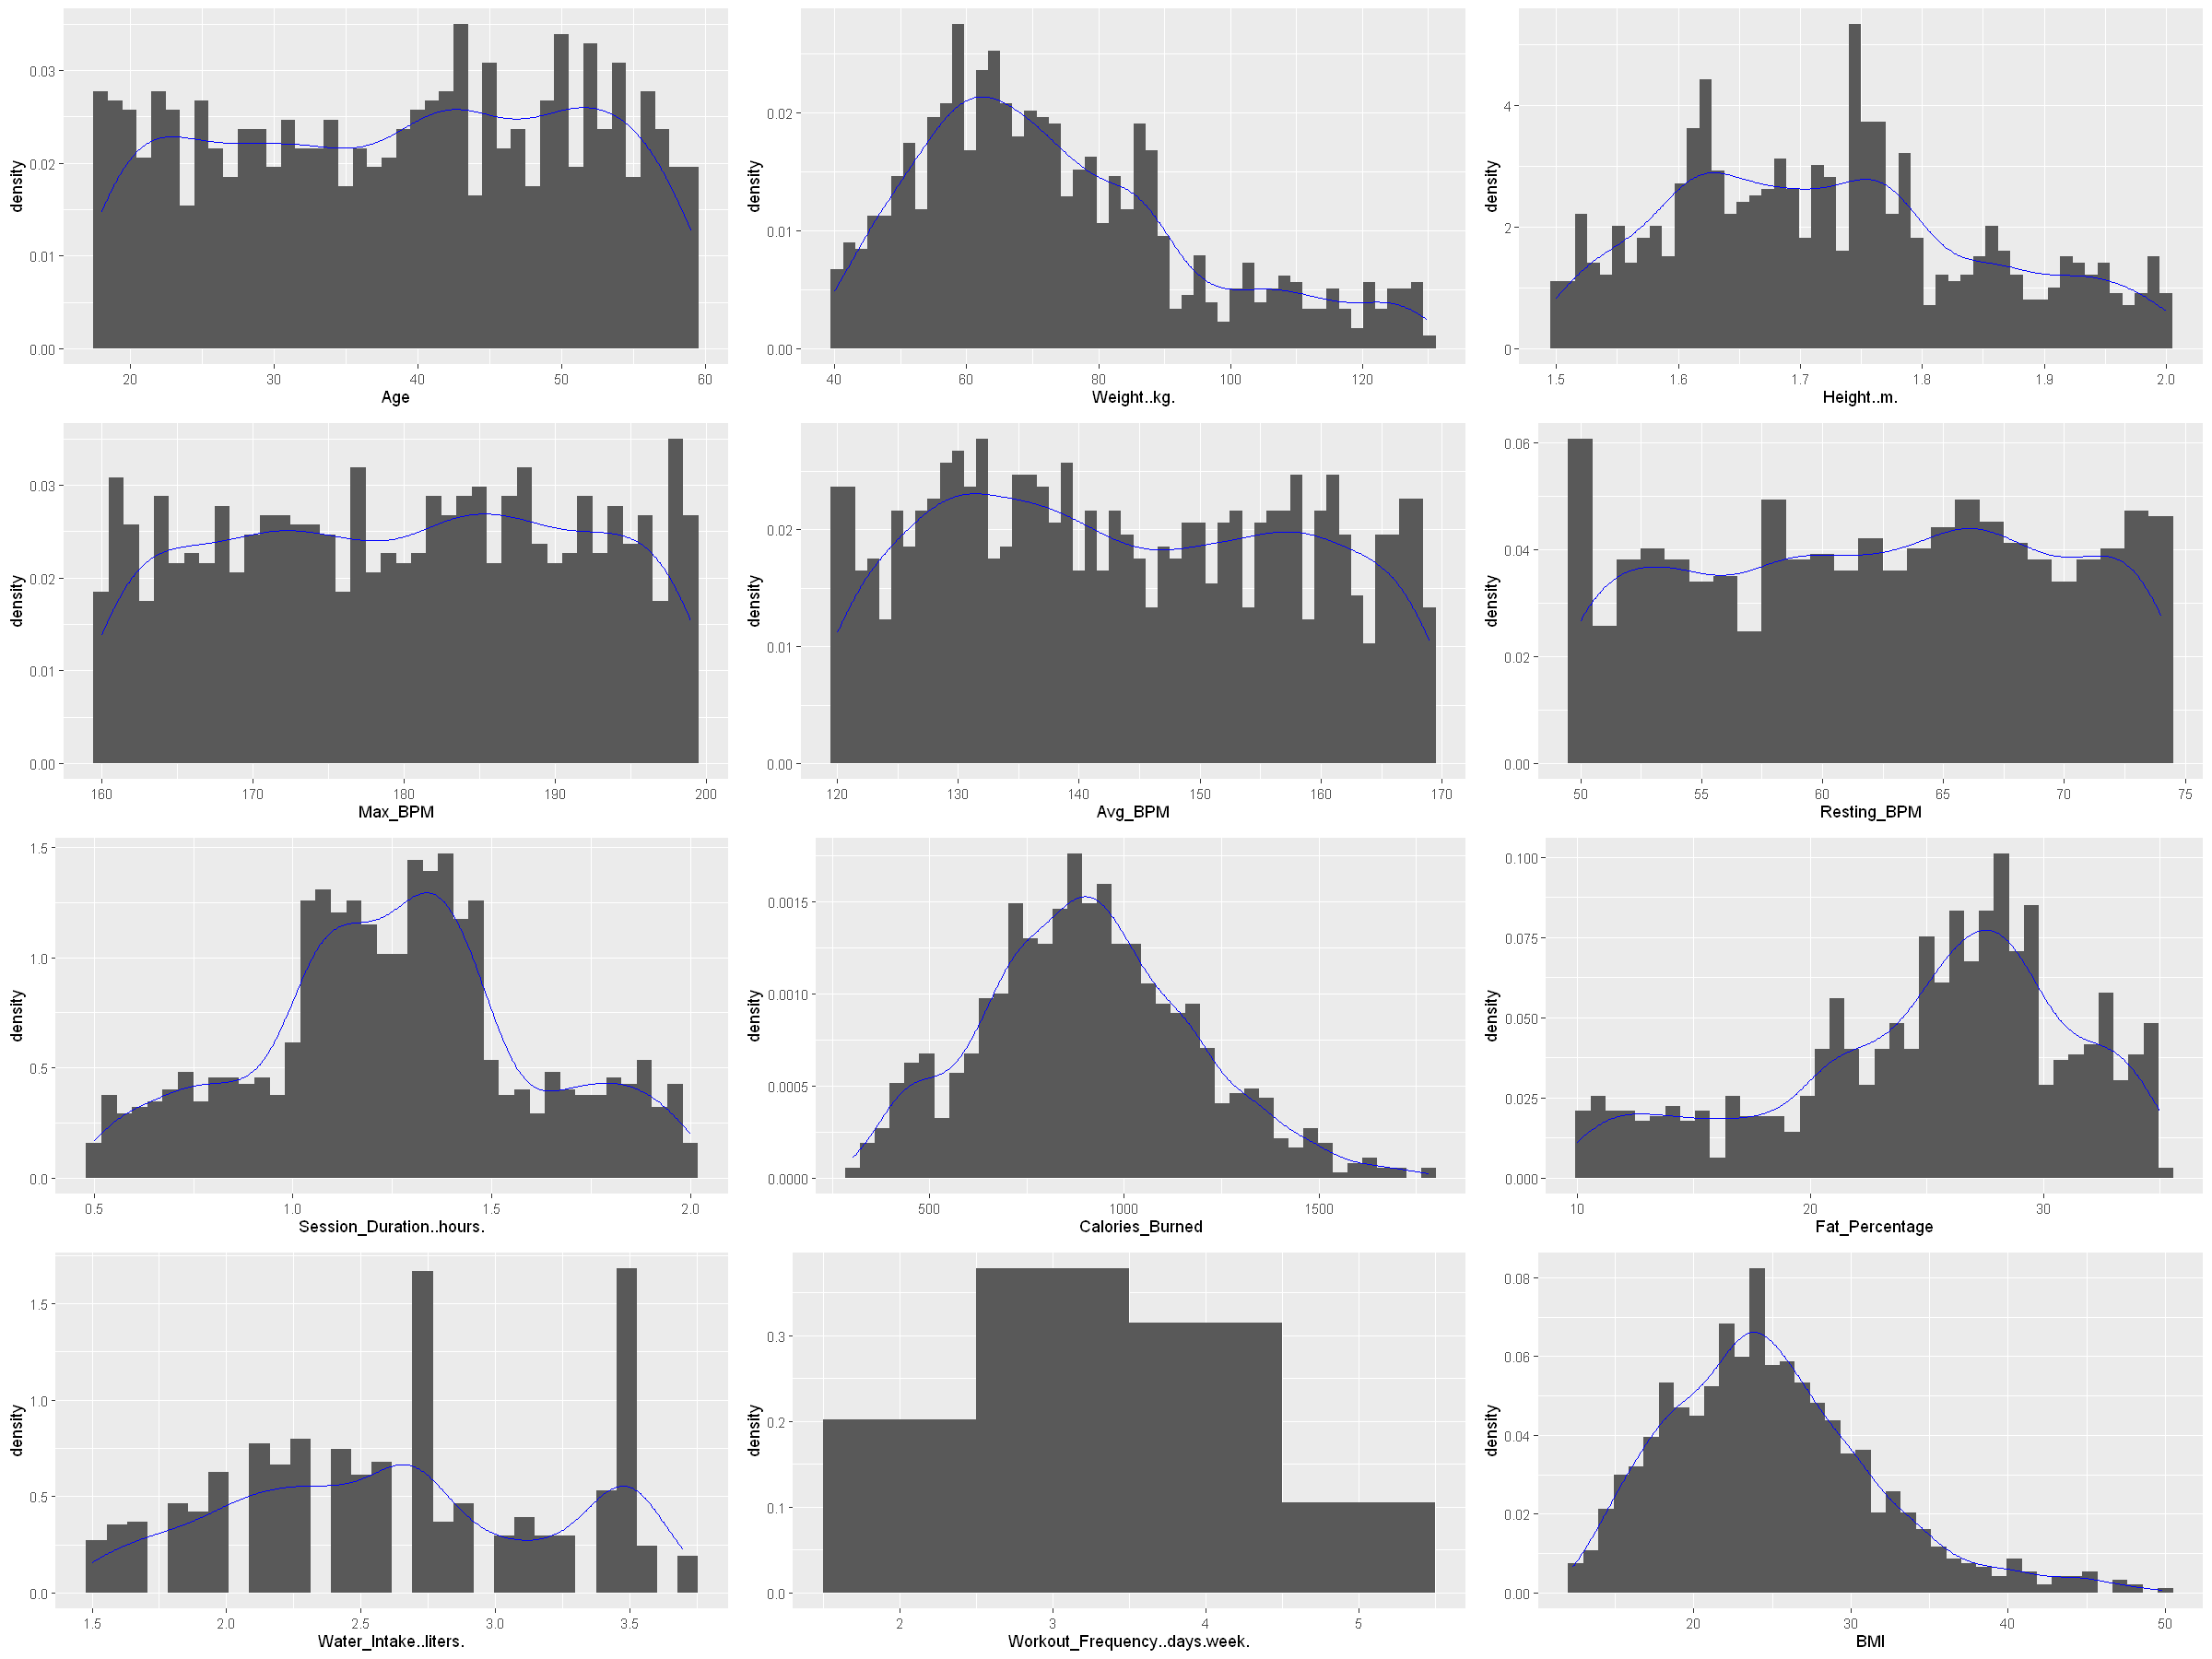

In [6]:
g1<-ggplot(gym,aes(x=Age))+geom_histogram(aes(y=..density..),bins=max(gym[,"Age"])-min(gym[,"Age"])+1)+geom_density(alpha=.2, col="blue") 
g2<-ggplot(gym,aes(x=Weight..kg.))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g3<-ggplot(gym,aes(x=Height..m.))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g4<-ggplot(gym,aes(x=Max_BPM))+geom_histogram(aes(y=..density..),bins=max(gym[,"Max_BPM"])-min(gym[,"Max_BPM"])+1)+geom_density(alpha=.2, col="blue") 
g5<-ggplot(gym,aes(x=Avg_BPM))+geom_histogram(aes(y=..density..),bins=max(gym[,"Avg_BPM"])-min(gym[,"Avg_BPM"])+1)+geom_density(alpha=.2, col="blue") 
g6<-ggplot(gym,aes(x=Resting_BPM))+geom_histogram(aes(y=..density..),bins=max(gym[,"Resting_BPM"])-min(gym[,"Resting_BPM"])+1)+geom_density(alpha=.2, col="blue")
g7<-ggplot(gym,aes(x=Session_Duration..hours.))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")
g8<-ggplot(gym,aes(x=Calories_Burned))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")
g9<-ggplot(gym,aes(x=Fat_Percentage))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")
g10<-ggplot(gym,aes(x=Water_Intake..liters.))+geom_histogram(aes(y=..density..),bins=30)+geom_density(alpha=.2, col="blue")
g11<-ggplot(gym,aes(x=Workout_Frequency..days.week.))+geom_histogram(aes(y=..density..),bins=4)
g12<-ggplot(gym,aes(x=BMI))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")


options(repr.plot.width=20, repr.plot.height=15)
grid.arrange(g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,ncol=3)

Analyse unidimensionnelle des variables quantitatives : 

- Age : répartition quasi-uniforme de la majorité à 60 ans
- Poids : répartition asymétrique (forme de courbe en chi-2) avec un pic aux alentours de 60kg
- Taille : répartition asymétrique, somme de deux gaussiennes, une centrée autour de 1m63 (correspondant aux femmes), et une centrée autour de 1m75 (correspondant aux hommes)
- BPM max : répartition quasi-uniforme de 160 à 200 bpm
- BPM moyen : répartition quasi-uniforme de 120 à 170 bpm
- BPM au repos : répartition quasi-uniforme de 50 à 75 bpm
- Durée de la session : répartition symétrique, similaire à une gaussienne ou une double gaussienne : on constate que les séances majoritaires sont celles entre 1h et 1h30
- Calories brûlées : répartition légèrement asymétrique, la majorité des séances brûlent moins que 1000 calories
- Pourcentage de masse graisseuse : répartition asymétrique, avec un pic autour de 27%
- Apport en eau : répartition asymétrique avec des pics aux alentours de 2.7L et 3.5L (en dehors de ces pics, on devine une gaussienne)
- Fréquence d'entraînement : la majorité des individus font 3 à 4 séances par semaine (sportifs réguliers)
- Indice de masse corporelle : répartition asymétrique (forme de courbe en chi-2) avec un pic aux alentours de 23

Analyse unidimensionnelle des variables qualitatives :

- un peu plus d'hommes que de femmes dans le jeu de données, mais ce n'est pas notable et pas suffisant pour que ça puisse biaiser nos résultats et conclusions.
- type d'entraînement : une répartition quasi-uniforme entre le cardio, l'entraînement fractionné de haute intensité (HIIT), la force athlétique et le yoga, on a donc tous types de profils.
- niveau d'expérience : majorité de personnes à niveaux 1 ou 2, le nombre de personnes de niveau 3 n'est pas négligeables bien que plus faible que les autres. Cela reflète la réalité de la population, il y a moins de personnes expérimentées qui vont à la salle de sport que de débutant ou intermédiaire. Cela ne devrait pas biaiser nos résultats d'analyse. 

On souhaite rendre les distributions asymétriques plus symétriques et "gaussiennes" pour pouvoir appliquer ensuite des techniques de modélisation linéaire. Pour cela, on teste des transformations  sur nos données et on retient celles qui donnent des résultats sensiblement plus symétriques que les distributions originelles. Ce sont les suivantes :

In [8]:
gym[,"LWeight..kg."] <- log((gym[,"Weight..kg."]))
gym[,"LBMI"] <- log((gym[,"BMI"]))

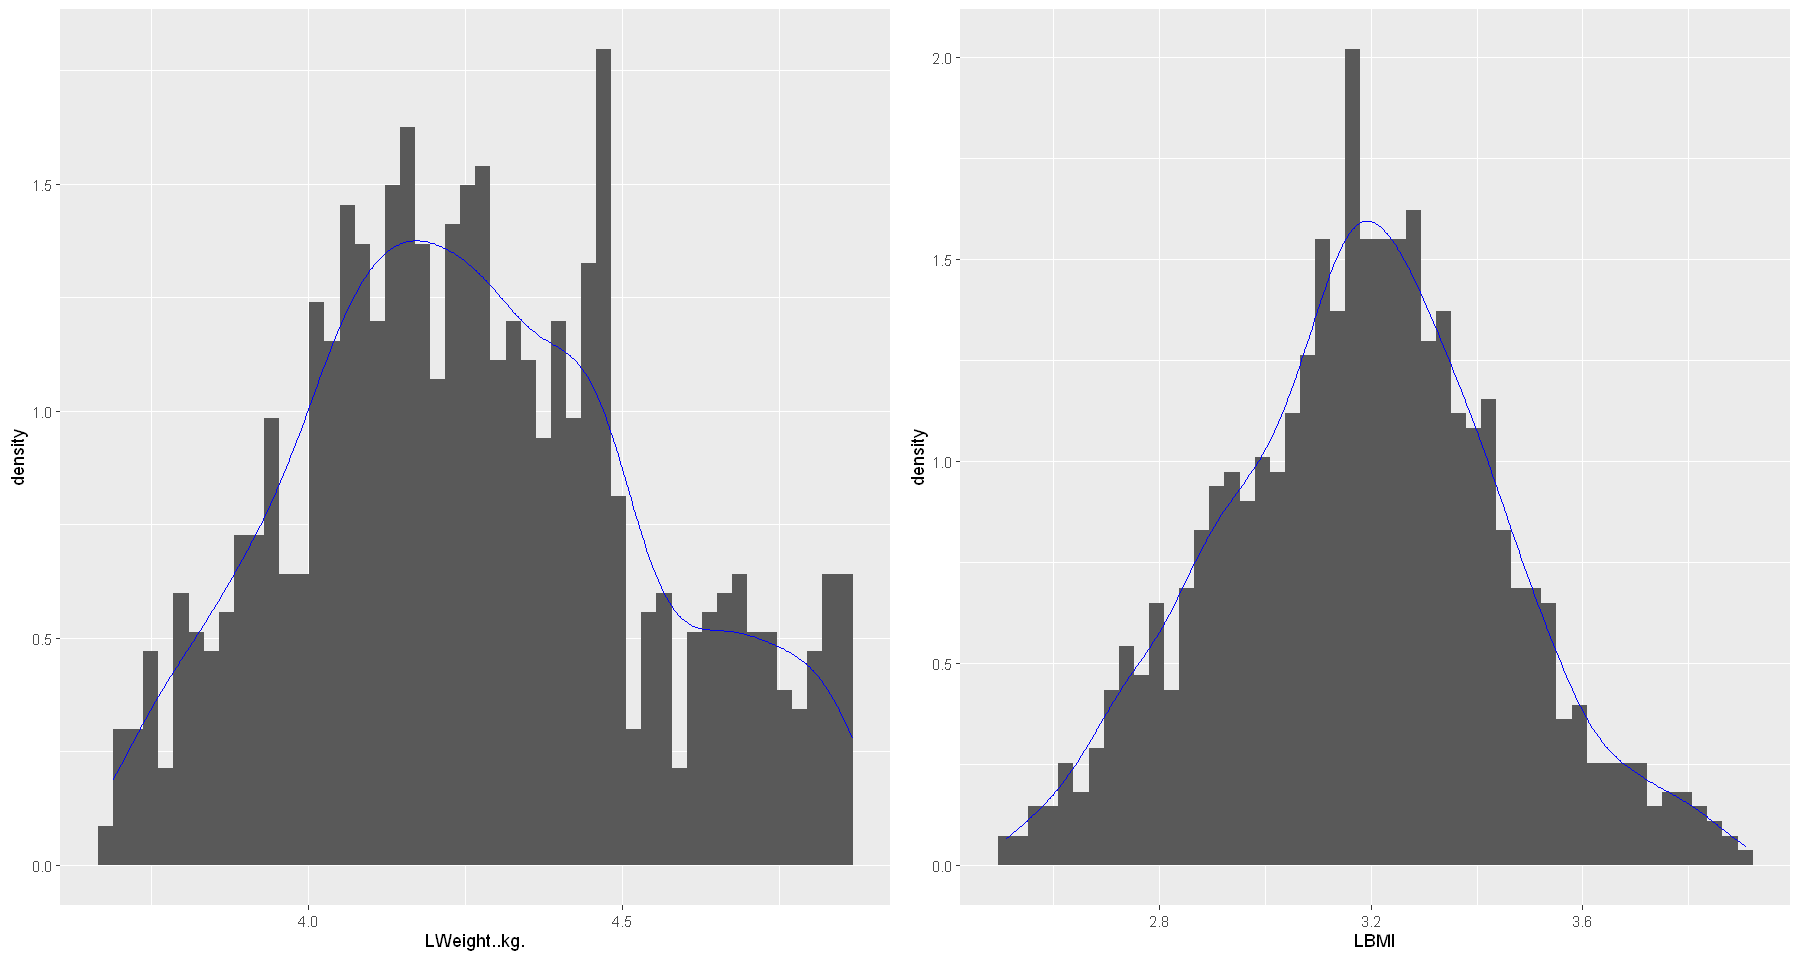

In [9]:
options(repr.plot.width=15, repr.plot.height=8)
g13<-ggplot(gym,aes(x=LWeight..kg.))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g17<-ggplot(gym,aes(x=LBMI))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
grid.arrange(g13,g17,ncol=2)

On peut voir que pour certaines variables comme $BMI$ la transformation a permis de faire apparaître très distinctement la symétrie alors que pour d'autres le résultat est moins flagrant comme $Height$ mais toujours mieux que la variable de base. 

On va désormais retirer les variables initiales et conserver les variables transformées.

In [10]:
head(gym)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI,LWeight..kg.,LBMI
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20,4.480740,3.407842
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00,4.316154,3.465736
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71,4.220977,3.207208
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41,3.974058,2.912894
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39,3.830813,2.666534
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55,4.060443,3.022861


In [11]:
gym<-gym[,c(1:2,4:14,16:17)]
head(gym)

,Age,Gender,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,LWeight..kg.,LBMI
,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>
1,56,Male,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,4.480740,3.407842
2,46,Female,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,4.316154,3.465736
3,32,Female,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,4.220977,3.207208
4,25,Male,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,3.974058,2.912894
5,38,Male,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,3.830813,2.666534
6,56,Female,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,4.060443,3.022861


### 4.Analyse Bidimensionelle

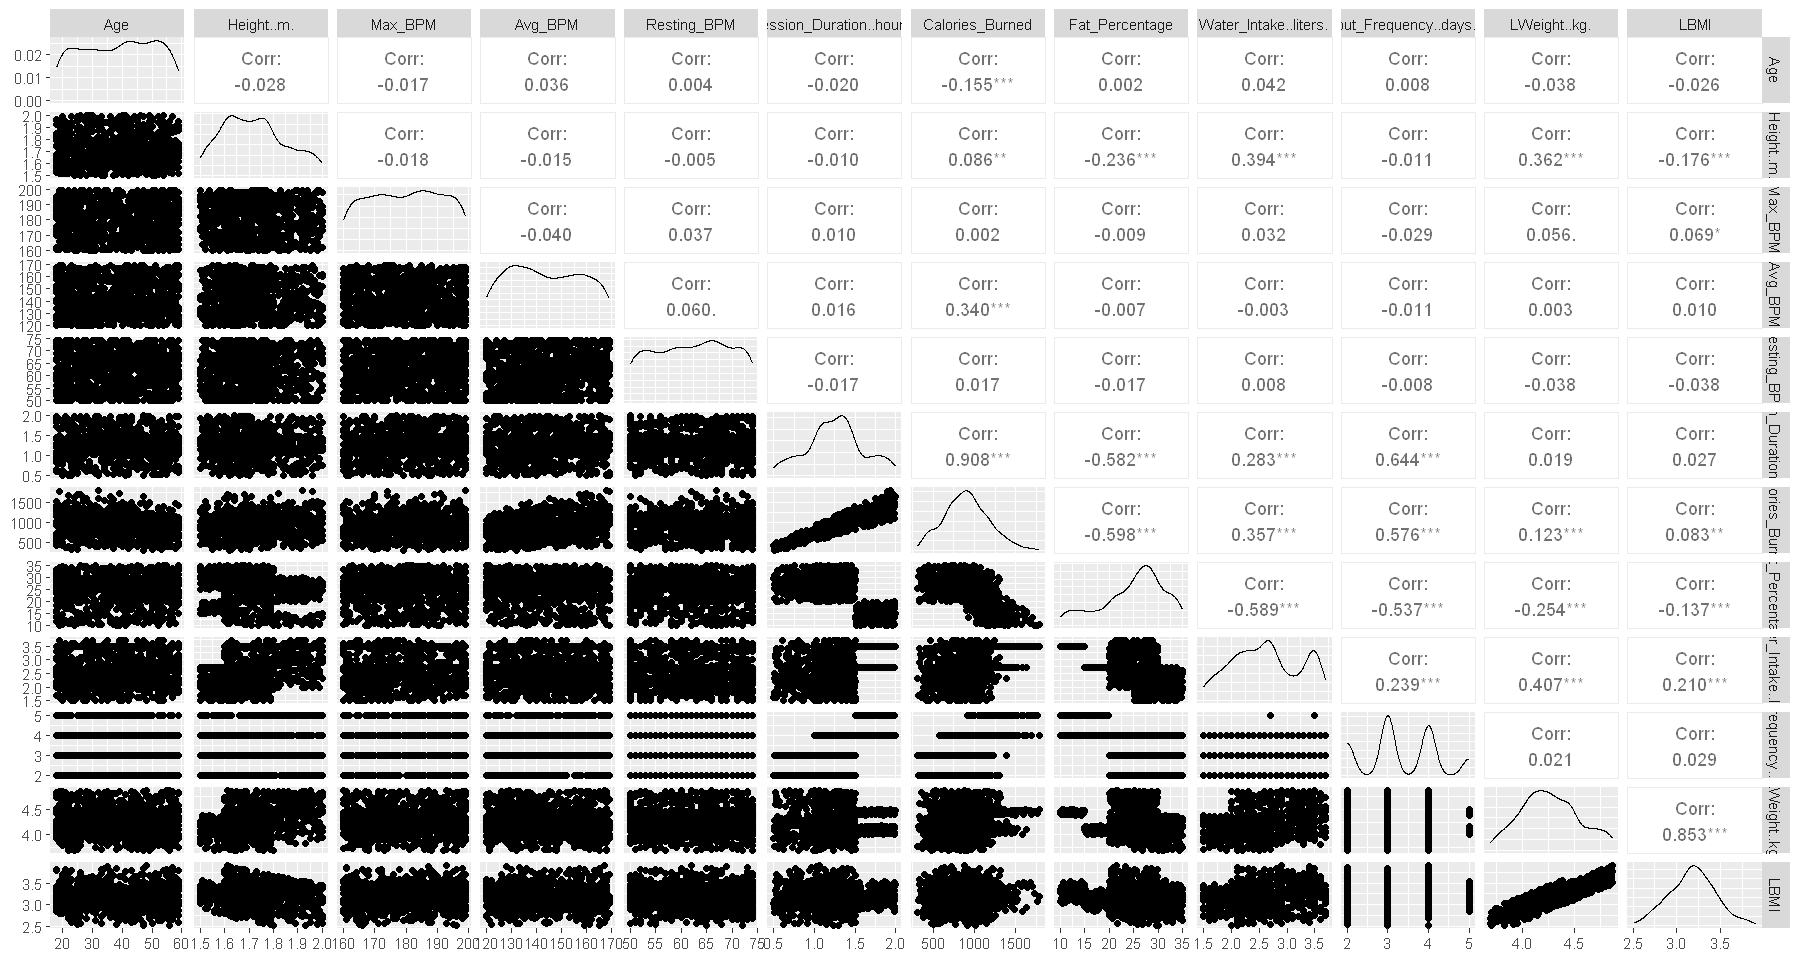

In [12]:
gym_num <- gym[, -c(2, 9, 13)]
ggpairs(gym_num)

On peut voir que l'on obtient des graphes où l'on a des points partout comme entre `Age` et `Height`. Ce n'est pas forcément une mauvaise chose, cela nous dit que notre jeu de données est bien uniforme et non biaisé car on a des gens de tout âge et toute taille.

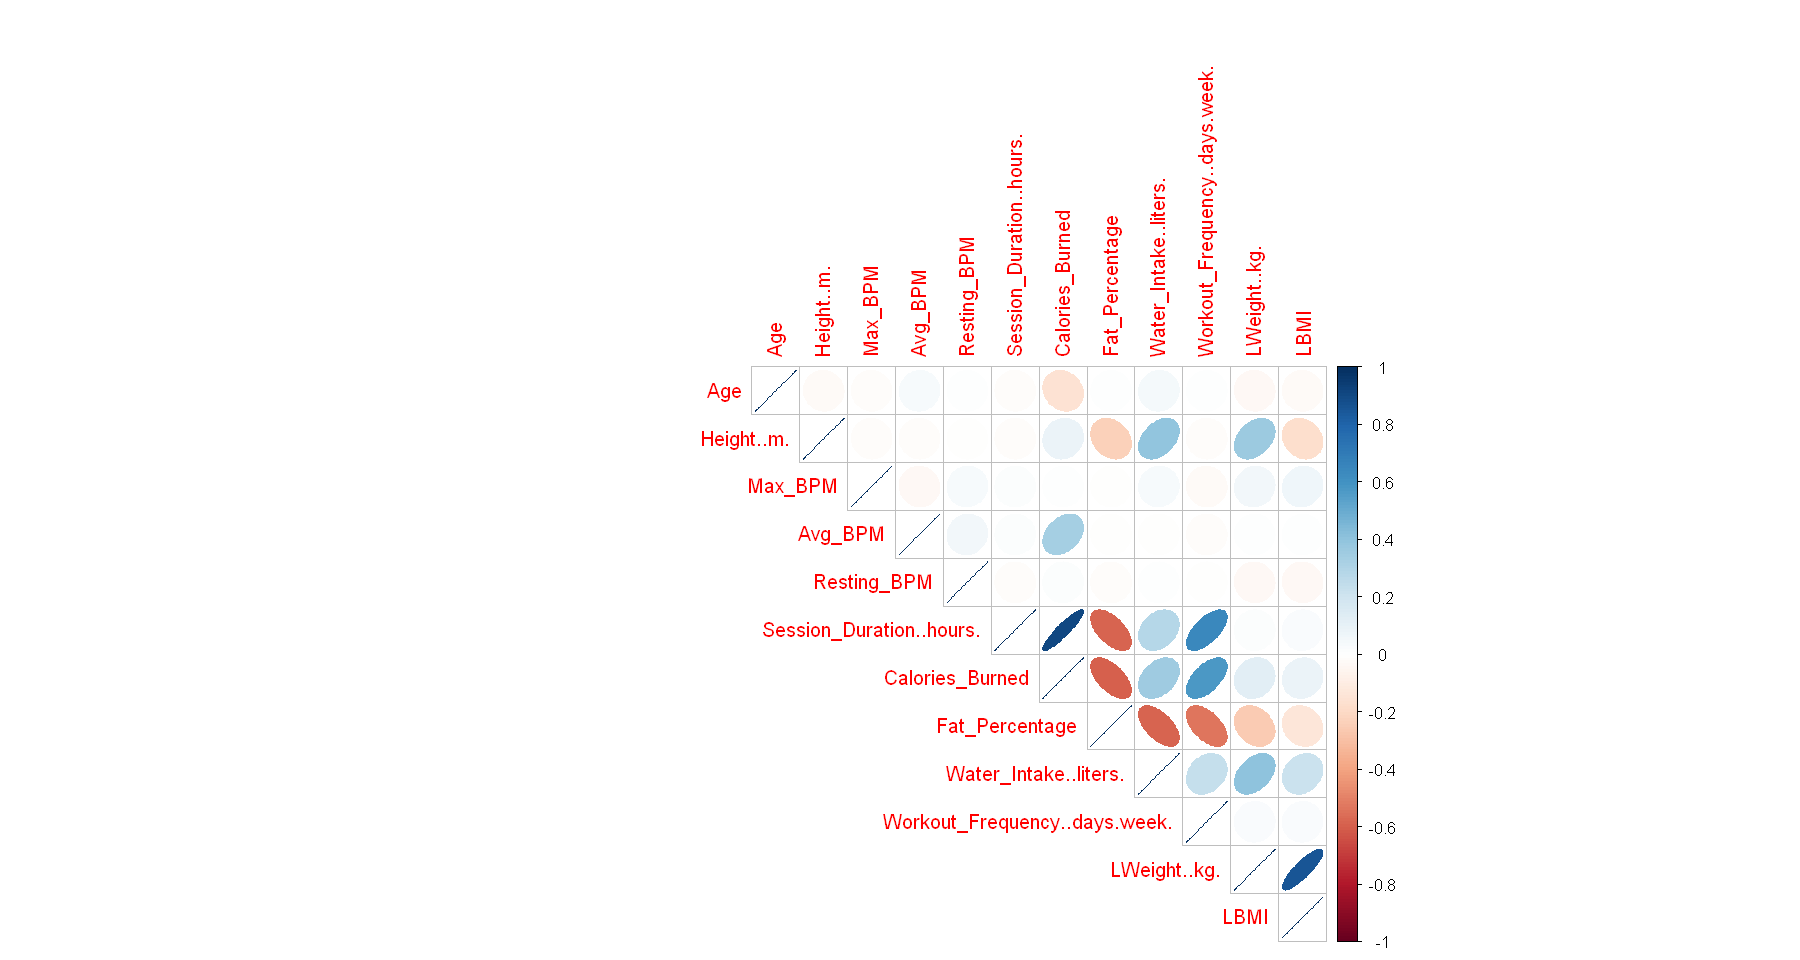

In [13]:
corrplot(cor(gym_num), method="ellipse",type="upper")

On remarque les corrélations significatives suivantes :

- les individus qui font des sessions plus longues brûlent davantage de calories par session (ce qui est cohérent), une relation linéaire semble en effet se dessiner entre ces deux variables
- les individus qui font des sessions plus longues ont tendance à avoir des pourcentages de masse graisseuse plus bas
- les individus qui font des sessions plus longues ont tendance à faire des séances plus souvent
- les individus qui brûlent beaucoup de calories par session ont tendance à avoir des pourcentages de masse graisseuse plus bas
- les individus qui brûlent beaucoup de calories par session ont tendance à faire des séances plus souvent
- les individus qui ont des pourcentages de masse graisseuse plus bas consomment davantage d'eau (ce qui est surprenant dans une certaine mesure!)
- les individus qui ont des pourcentages de masse graisseuse plus bas ont tendance à faire des séances plus souvent (cohérent)
- plus les individus sont lourds, plus leur IMC a tendance à être elevé (ce qui est cohérent car c'est l'un des facteurs rentrant dans le calcul de l'IMC), on observe en effet une relation linéaire entre le log de ces deux variables, ce qui est cohérent car IMC=masse/taille**2

### 5. ACP

On cherche à prédire le nombre de calories brulée en fonction des autres variables, on les retire donc pour réaliser l'ACP

In [14]:
# ACP réduite
acp <- PCA(gym, scale.unit = TRUE,
           graph = FALSE, quanti.sup=8,quali.sup = c(2,9,13), ncp=6)


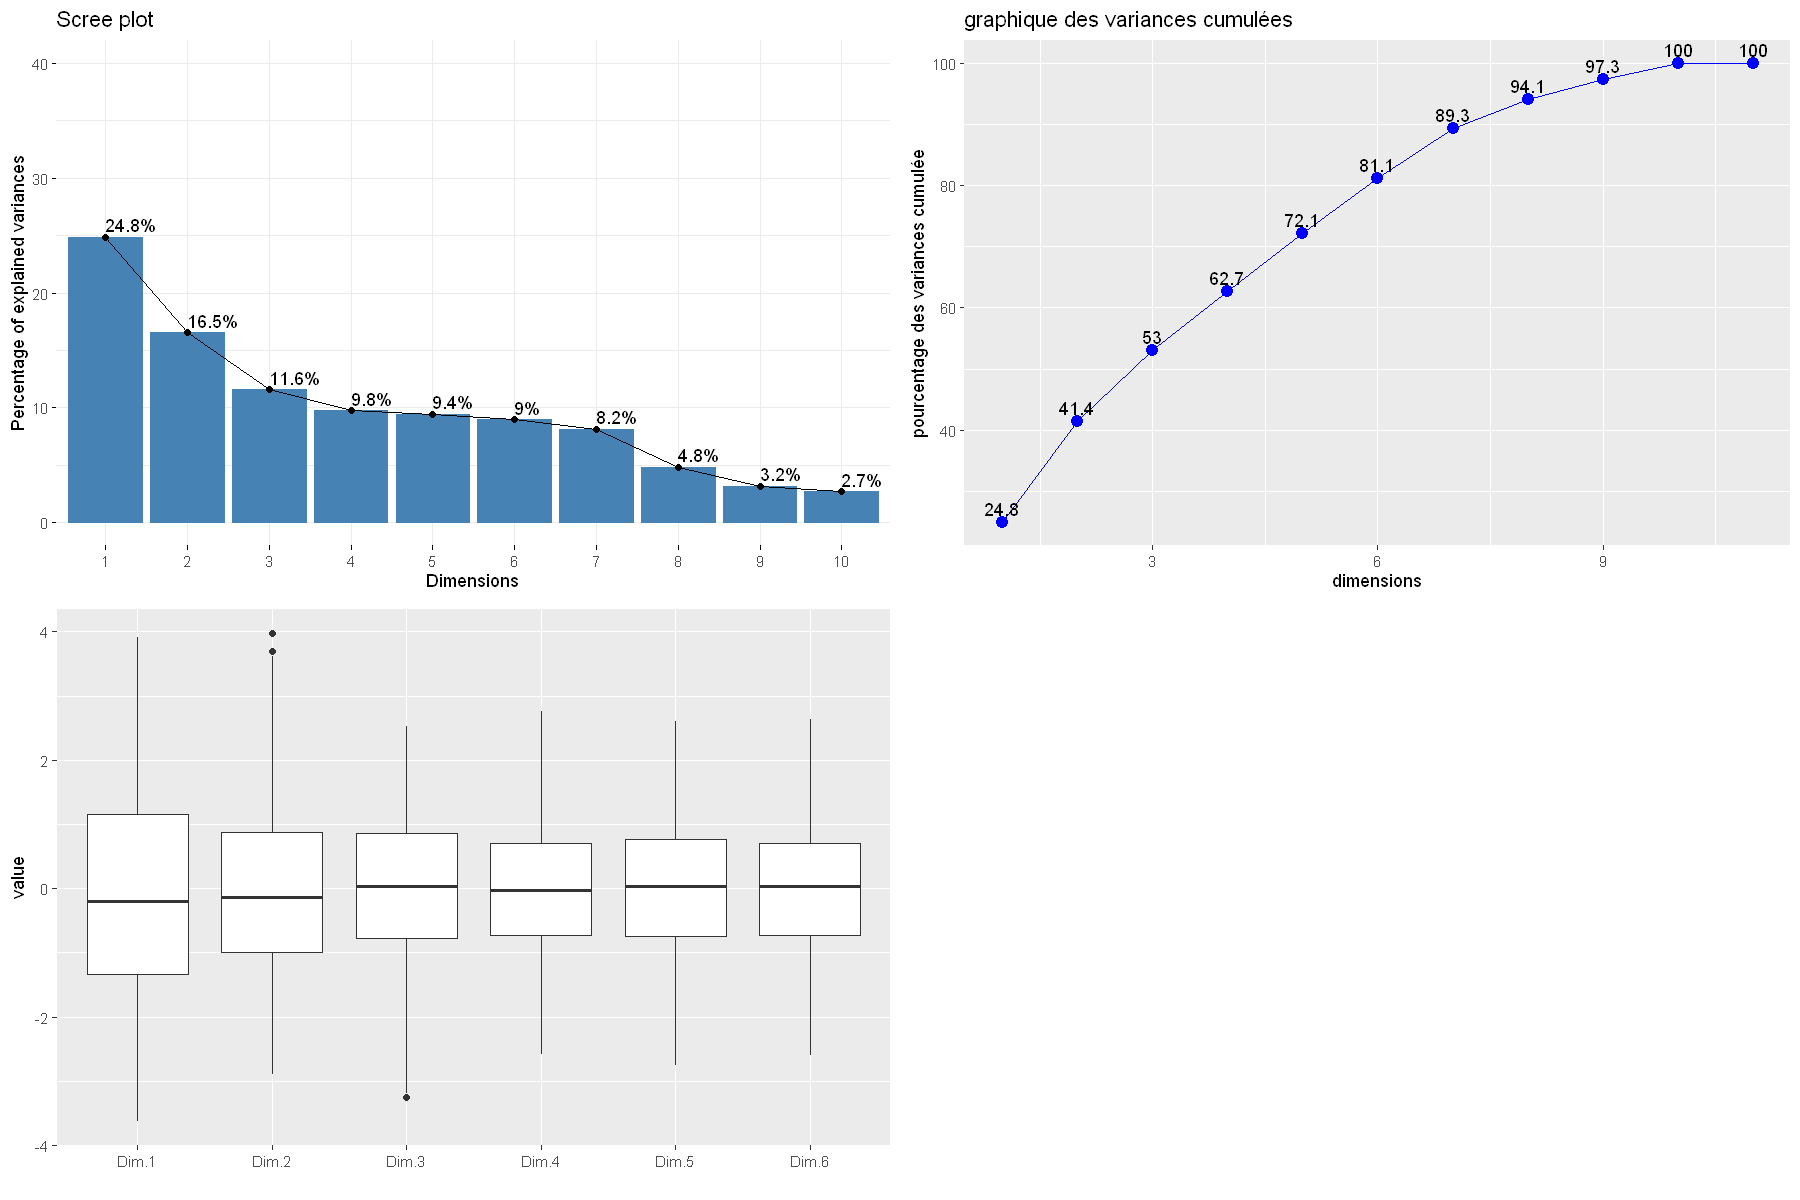

In [15]:
options(repr.plot.width = 15, repr.plot.height = 10) 
# Décroissance des valeurs propres
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))

#variance cumulées 
cum_var <- cumsum(acp$eig[, 2]) 

# Graphique avec ggplot2
g2<-ggplot(data.frame(Dimension = 1:length(cum_var), Variance = cum_var), aes(x = Dimension, y = Variance)) +
    geom_point(size = 3, color = "blue") +
    geom_line(color = "blue") +
    labs(title = "graphique des variances cumulées",x='dimensions', y = "pourcentage des variances cumulée") +
    geom_text(aes(y = cum_var, label = round(cum_var, 1)), vjust = -0.5, color = "black") 

g3<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,g3,ncol=2)

On choisit de garder six dimensions pour expliquer 80% de la variance. On aurait pu également garder moins de dimensions pour une meilleure visualisation car la variance expliquée par on observe un coude dans la variance expliquée par les dimensions à partir de 3, mais cela nous ferait perdre beaucoup d'information.

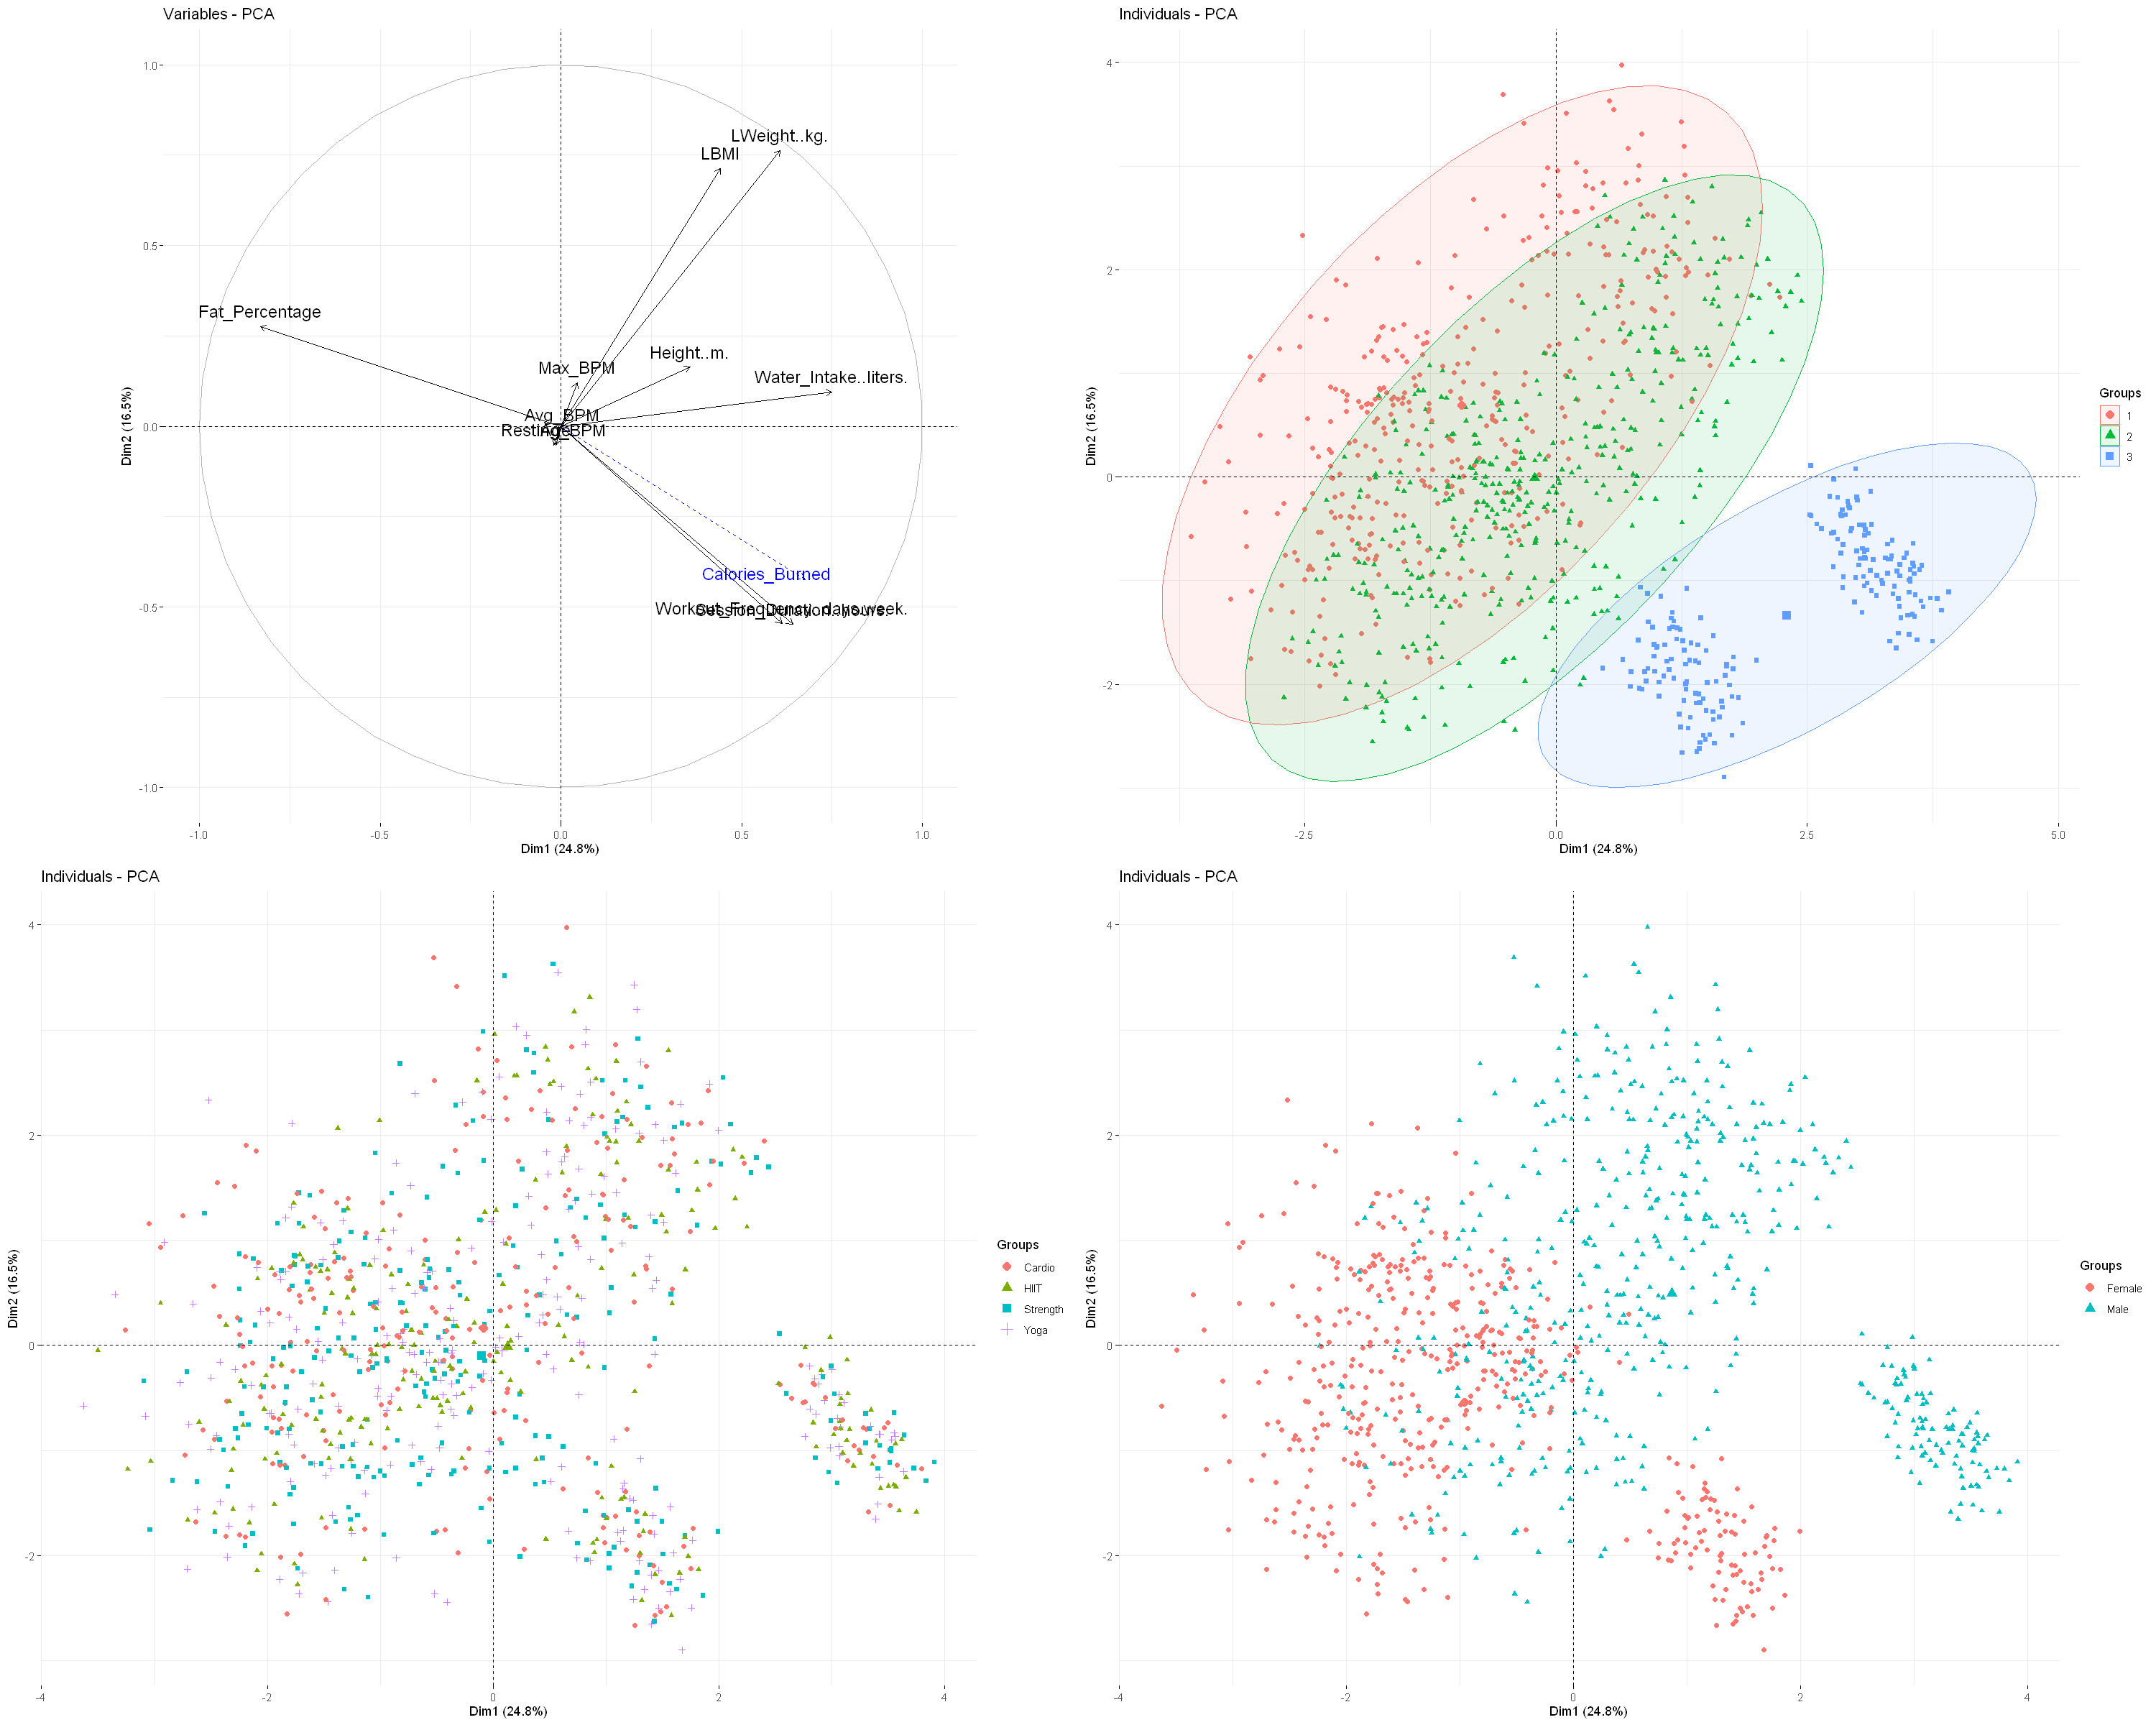

In [16]:
options(repr.plot.width = 25, repr.plot.height = 20) 
g4<-fviz_pca_var(acp,labelsize = 5)
g5<-fviz_pca_ind(acp, habillage=gym$Experience_Level,label="none",addEllipses=TRUE, ellipse.level=0.95)
g6<-fviz_pca_ind(acp, habillage=gym$Workout_Type,label="none")
g7<-fviz_pca_ind(acp, habillage=gym$Gender,label="none")

grid.arrange(g4,g5,g6,g7,nrow=2,ncol=2)


Il semble difficile d'expliciter ce que pourraient représenter les dimensions. Néanmoins, on peut voir que la dimension 1 semble lié au niveau d'expérience. En effet, on peut observer sur le graphique des individus que la séparation entre le groupe d'expérience 3 (experts) et les autres semble bien linéaire. En regardant le graphe des variables, on voit que le pourcentage de masse graisseuse a une contribution fortement négatives à la dimension 1 à l'opposé de la durée des sessions, le nombre de sessions, la consommation d'eau qui ont une contribution positive. Ce qui représente donc bien la régularité d'entraînement et le niveau.
Lorsque l'on colorie en fonction du type d'entrainement, on observe pas de séparations claires dans le premier plan factoriel.
On remarque que pour le groupe d'experts (expérience 3), on distingue 2 groupes distincts dans le premier plan factoriel. En regardant les variables dans le premier plan factoriel, cette séparation semble pouvoir être expliquée par le poids et la taille, on en déduit une potentielle discrimination de genre. En coloriant selon le genre dans le premier plan factoriel, on confirme cette hypothèse.

Comme vu dans le corrplot, les calories brûlées sont corrélées positivement avec le nombre de sessions, la durée des sessions et négativement avec le pourcentage de masse graisseuse, ainsi on s'attend bien à ce qu'elle soit corrélées positivement avec la dimension 1.

On effectue une seconde ACP avec le nombre de calories brulées dans le but futur de prédire le niveau d'expérience. On ne va pas l'interpréter car les résultats sont très similaires à l'acp précédente, elle nous servira juste pour la prédiction.

In [17]:
acp_level <- PCA(gym, scale.unit = TRUE,
           graph = FALSE, quali.sup = c(2,9,13), ncp=6)

## II. Prédiction des calories brûlées

In [18]:
MSE <- function(Y, Y_pred) {
  return(mean((Y - Y_pred)^2))
}

R2 <- function(Y, Y_pred) {
  ssr <- sum((Y - Y_pred)^2)
  sst <- sum((Y - mean(Y))^2)
  return(1-ssr/sst)
}

### 1. Division en échantillon d'apprentissage et en échantillon de test

In [19]:
set.seed(1)

# 1. Colonnes catégorielles → variables indicatrices (one-hot encoding)
gym_dummies <- model.matrix(~ Gender + Workout_Type + Experience_Level - 1, data = gym) %>% as.data.frame()

# 2. Colonnes numériques (quantitatives)
gym_quant <- gym %>% select(
  Age, Height..m., Max_BPM, Avg_BPM, Resting_BPM,
  Session_Duration..hours., Fat_Percentage, Water_Intake..liters.,
  Workout_Frequency..days.week., LWeight..kg., LBMI
)

# 3. Combinaison des deux en un seul dataset
gym_new <- bind_cols(gym_dummies, gym_quant)

# 4. Variable cible
calories_burned <- gym$Calories_Burned
#use 80% of dataset as training set and 20% as test set
sample <- sample(c(TRUE, FALSE), nrow(gym_new), replace=TRUE, prob=c(0.8,0.2))
gym_train  <- gym_new[sample, ]
gym_test   <- gym_new[!sample, ]
calories_burned_train <- calories_burned[sample]
calories_burned_test <- calories_burned[!sample]

gym_r <- scale(gym_new)
# Standardisation des données d'entraînement
gymr_train <- gym_r[sample, ]
gymr_test <- gym_r[!sample, ]

Cette étape est nécessaire car on aurait un estimateur trop optimiste de l'erreur de généralisation si on testait sur le même échantillon que celui utilisé pour l'apprentissage.

### 2. Prédiction avec un modèle linéaire

On va utiliser un modèle linéaire classique et pas généralisé car dans l'analyse exploratoire, on a observé que la distribution des calories brûlées semblait gaussienne (et non Poisson ou gamma).

#### a. Modèle complet


Call:
lm(formula = calories_burned_train ~ ., data = gym_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-121.992  -24.789   -1.877   21.433  174.012 

Coefficients: (1 not defined because of singularities)
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -800.7590   230.6708  -3.471 0.000547 ***
GenderFemale                   -87.2463     5.7834 -15.086  < 2e-16 ***
GenderMale                           NA         NA      NA       NA    
Workout_TypeHIIT                 0.7309     4.1059   0.178 0.858759    
Workout_TypeStrength             1.2715     3.9818   0.319 0.749564    
Workout_TypeYoga                -2.5736     4.0678  -0.633 0.527139    
Experience_Level2               -6.5321     4.7140  -1.386 0.166249    
Experience_Level3              -10.1113    11.1583  -0.906 0.365133    
Age                             -3.4081     0.1186 -28.746  < 2e-16 ***
Height..m.                      22.2619   288.7076   0.

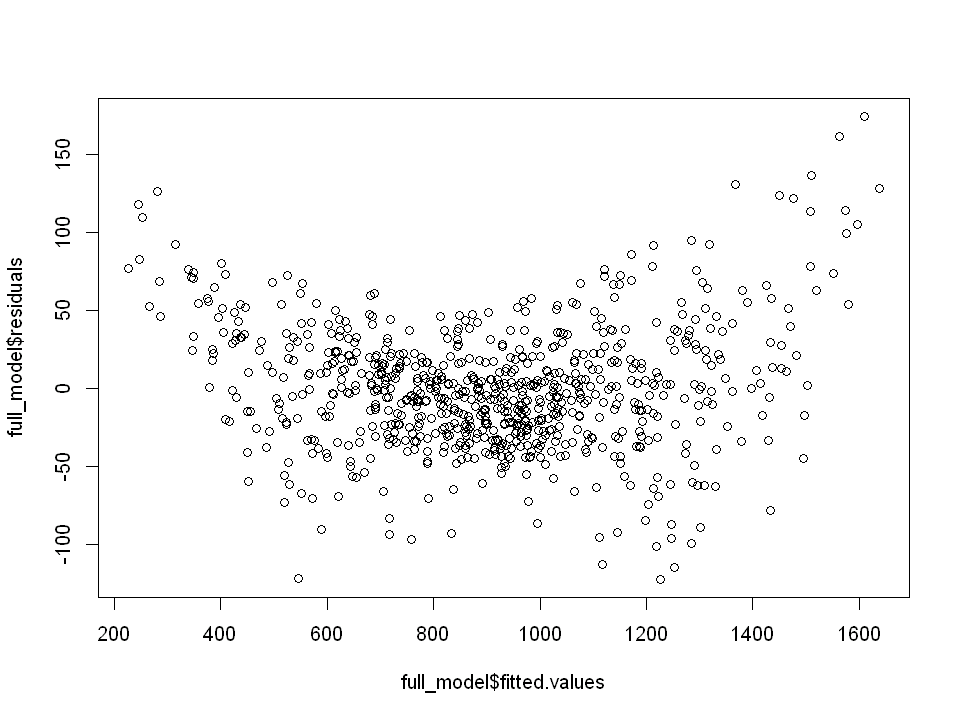

In [29]:
full_model<-lm(calories_burned_train~.,data=gym_train)
summary(full_model)
options(repr.plot.width=8,repr.plot.height=6)
plot(full_model$fitted.values, full_model$residuals)

Les variables importantes dans la prédiction des calories brûlées sont le genre, l'âge, le BPM moyen, le BPM au repos et la durée de la session. Les autres ne semblent pas avoir une réelle influence (p-valeur > 0.05), on pourra donc essayer un modèle de forward-selection basée sur l'AIC. En affichant le graphe des résidus, les hypothèses du modèle linéaire ne sont pas respectées : on n'a pas l'homoscédasticité, il semble y avoir une dépendance quadratique des résidus en fonction des valeurs prédites.

In [23]:
pred_full_model <- predict(full_model, gym_test)
mse_lm_full <- MSE(calories_burned_test,pred_full_model)
R2_lm_full <- R2(calories_burned_test,pred_full_model)
bic_lm_full <- BIC(full_model)
paste("MSE: ",mse_lm_full,sep="")
paste("R2: ",R2_lm_full ,sep="")
paste("BIC: ",bic_lm_full,sep="")

[1] "MSE: 1560.74172215946"

[1] "R2: 0.977028793703263"

[1] "BIC: 8058.09542671727"

#### b. Avec une forward-selection basée sur l'AIC (sans et avec interactions)

In [33]:
empty_model<-lm(calories_burned_train~1,data=gym_train)
model_lin_forward <- stepAIC(empty_model, direction = "forward", scope = formula(full_model))
summary(model_lin_forward)

Start:  AIC=8754.92
calories_burned_train ~ 1

                                Df Sum of Sq      RSS    AIC
+ Session_Duration..hours.       1  48962880 10099619 7381.1
+ Experience_Level3              1  25331071 33731429 8320.5
+ Fat_Percentage                 1  21425635 37636864 8405.9
+ Workout_Frequency..days.week.  1  18956030 40106470 8455.4
+ Water_Intake..liters.          1   7920405 51142094 8644.8
+ Avg_BPM                        1   7324149 51738350 8653.8
+ Age                            1   1696642 57365858 8734.2
+ GenderFemale                   1   1447310 57615189 8737.6
+ GenderMale                     1   1447310 57615189 8737.6
+ LWeight..kg.                   1    973327 58089173 8744.0
+ LBMI                           1    474654 58587846 8750.6
+ Height..m.                     1    440186 58622314 8751.1
<none>                                       59062499 8754.9
+ Workout_TypeStrength           1    108858 58953642 8755.5
+ Resting_BPM                    1    


Call:
lm(formula = calories_burned_train ~ Session_Duration..hours. + 
    Avg_BPM + GenderFemale + Age + Resting_BPM + LBMI, data = gym_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-124.411  -25.248   -2.872   21.775  176.015 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -773.24324   26.97973 -28.660   <2e-16 ***
Session_Duration..hours.  716.89618    4.14807 172.826   <2e-16 ***
Avg_BPM                     6.23178    0.09936  62.718   <2e-16 ***
GenderFemale              -87.30892    2.98047 -29.294   <2e-16 ***
Age                        -3.41142    0.11695 -29.169   <2e-16 ***
Resting_BPM                 0.47718    0.19553   2.440   0.0149 *  
LBMI                        8.41659    5.56825   1.512   0.1311    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 39.64 on 772 degrees of freedom
Multiple R-squared:  0.9795,	Adjusted R-squared:  0.9793 
F-statist

Les variables sélectionnées sont la durée de la session, le BPM moyen, le genre, l'âge, le BPM au repos et le log-IMC.

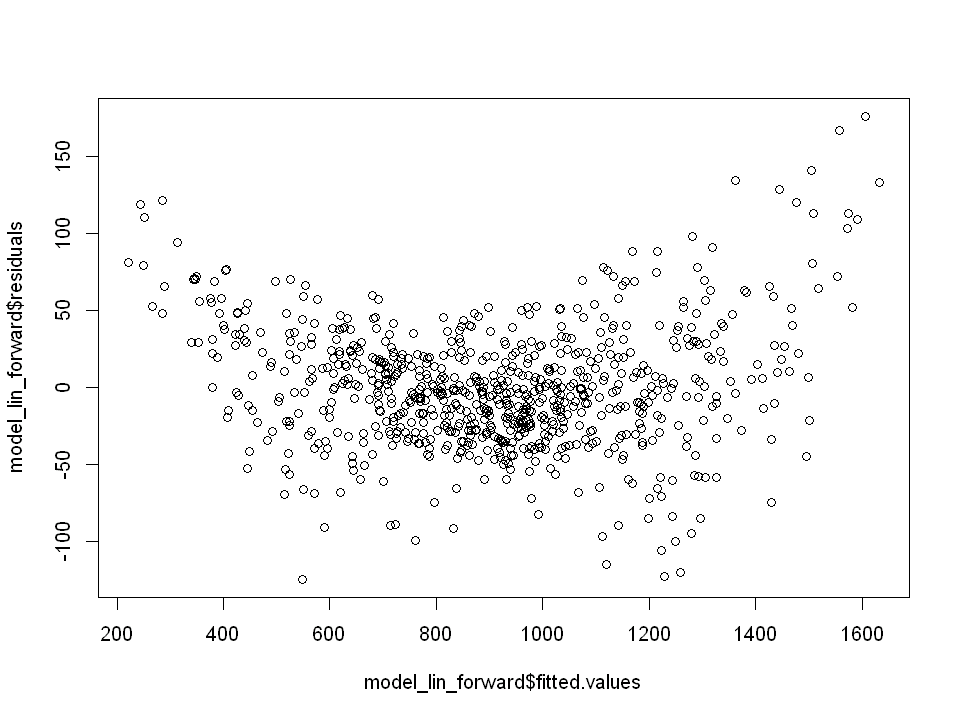

In [34]:
plot(model_lin_forward$fitted.values, model_lin_forward$residuals)

On a toujours cette tendance quadratique (hétéroscédacticité) des résidus. Pour le prochain modèle, on va ajouter les interactions pour voir ce phénomène disparaître.

In [35]:
pred_model_lin_forward <- predict(model_lin_forward, gym_test)
mse_lm_forward <- MSE(calories_burned_test,pred_model_lin_forward)
R2_lm_forward <- R2(calories_burned_test,pred_model_lin_forward)
bic_lm_forward <- BIC(model_lin_forward)
paste("MSE: ",mse_lm_forward,sep="")
paste("R2: ",R2_lm_forward ,sep="")
paste("BIC: ",bic_lm_forward ,sep="")

[1] "MSE: 1548.20345059426"

[1] "R2: 0.977213333668229"

[1] "BIC: 7990.16103501516"

On a des résultats légèrement meilleurs mais pas d'amélioration notable.

On part d'un modèle intercept only et avec une sélection de variable forward par AIC, on va ajouter au fur et à mesure les variables ou interactions entre variables qui font baisser le plus cet indicateur.

In [36]:
empty_model<-lm(calories_burned_train~1,data=gym_train)
full_model_int <- lm(calories_burned_train~.^2,data=gym_train)
model_lin_forward_int <- stepAIC(empty_model, direction = "forward", scope = formula(full_model_int), trace = 0)
summary(model_lin_forward_int)


Call:
lm(formula = calories_burned_train ~ Session_Duration..hours. + 
    Avg_BPM + GenderFemale + Age + Workout_TypeStrength + LBMI + 
    Resting_BPM + Workout_Frequency..days.week. + Max_BPM + Water_Intake..liters. + 
    Session_Duration..hours.:Avg_BPM + Session_Duration..hours.:GenderFemale + 
    Session_Duration..hours.:Age + Avg_BPM:GenderFemale + Avg_BPM:Age + 
    GenderFemale:Age + Session_Duration..hours.:Workout_TypeStrength + 
    LBMI:Resting_BPM + Workout_TypeStrength:LBMI + GenderFemale:Workout_TypeStrength + 
    LBMI:Max_BPM + Avg_BPM:Workout_Frequency..days.week., data = gym_train)

Residuals:
   Min     1Q Median     3Q    Max 
-71.03 -17.19  -0.88  14.97  80.28 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                   -4.928e+02  1.951e+02  -2.526
Session_Duration..hours.                       2.024e+02  3.568e+01   5.673
Avg_BPM                                        1.047e+00  3.3

Le modèle forward avec interactions sélectionne beaucoup de variables qui ne semblent pas nécessairement utiles pour la prédiction.

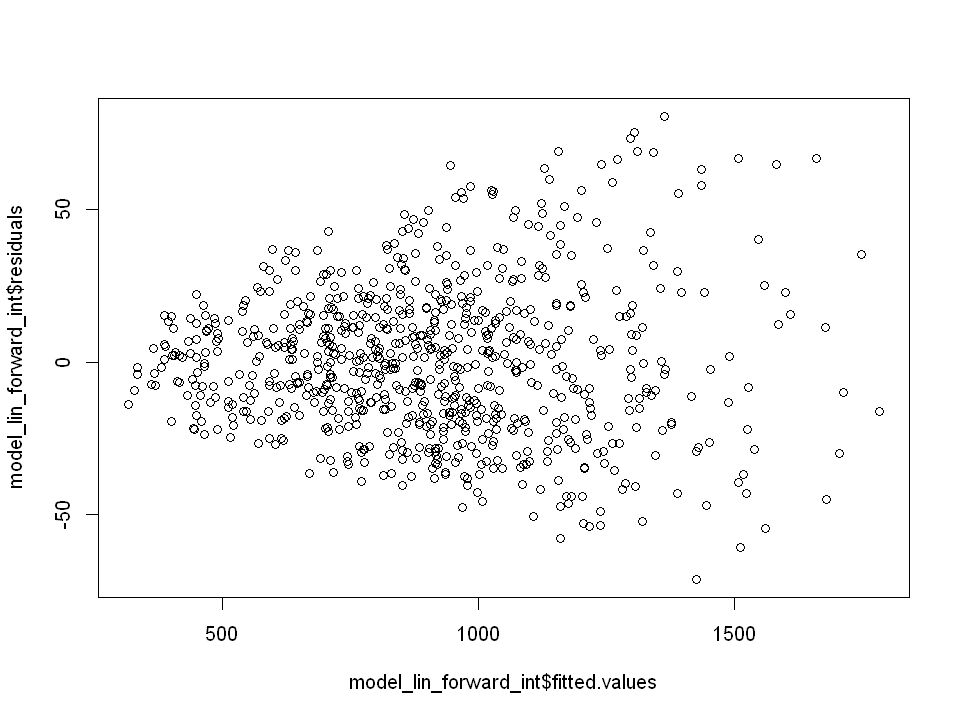

In [37]:
plot(model_lin_forward_int$fitted.values, model_lin_forward_int$residuals)

Ce modèle linéaire avec interactions ne vérifie toujours pas l'hypothèse d'homoscédasticité, mais nous n'avons plus la pseudo-dépendance quadratique des résidus
par rapport aux valeurs prédites observée précédemment avec le modèle sans interactions.

In [38]:
pred_model_lfi <- predict(model_lin_forward_int, gym_test)
mse_lm_forward_int <- MSE(calories_burned_test,pred_model_lfi)
R2_lm_forward_int <- R2(calories_burned_test,pred_model_lfi)
bic_lm_forward_int <- BIC(model_lin_forward_int)
paste("MSE: ",mse_lm_forward_int,sep="")
paste("R2: ",R2_lm_forward_int ,sep="")
paste("BIC: ",bic_lm_forward_int ,sep="")

[1] "MSE: 672.708286329194"

[1] "R2: 0.990098989087437"

[1] "BIC: 7349.18449639482"

Le modèle forward avec interactions donne des résultats largement meilleurs que celui sans interactions, on voit en effet que la MSE sur le jeu de test a été divisée par un facteur supérieur à 2. 

#### c. Avec une pénalisation (LASSO / Ridge)

[1] "CV estimate of lambda : 1.459"

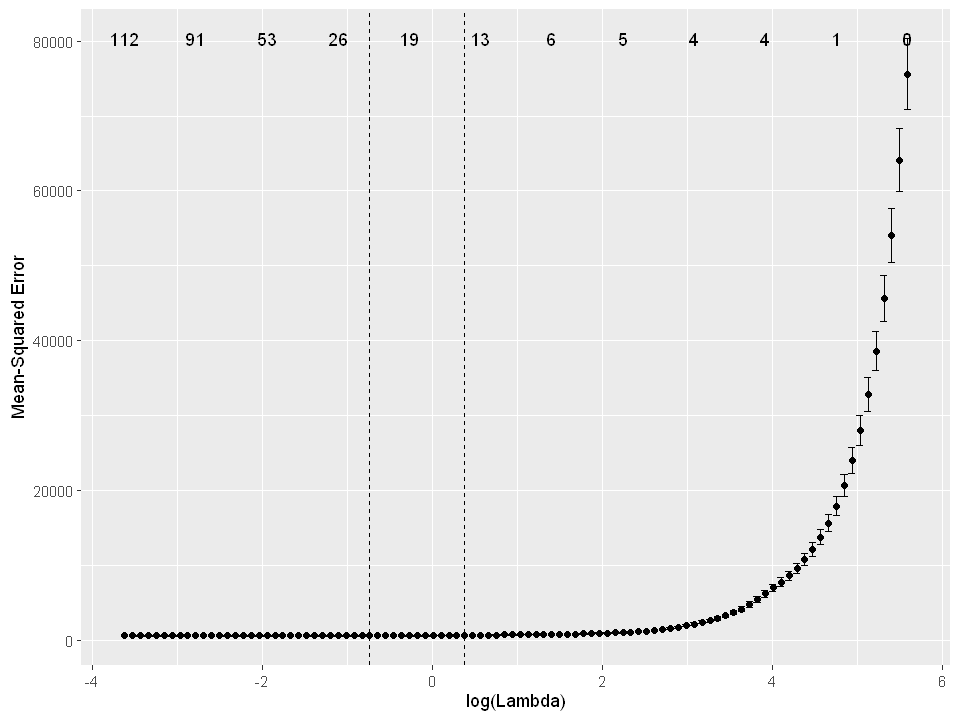

In [39]:
library(glmnet)
x.mat <- model.matrix(calories_burned_train ~ .^2 - 1, data = gym_train)
reg.lasso.cv <- cv.glmnet(y = calories_burned_train, x = x.mat)
autoplot(reg.lasso.cv)
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))

La validation croisée sur le modèle LASSO avec interactions suggère un paramètre lambda de pénalisation L1 égal à 1.459, en choisissant le 1SE car il donne un modèle plus simple avec moins de variables, mais des performances similaires sur le jeu de données d'apprentissage.

In [41]:
#coef(reg.lasso.cv, s = "lambda.1se")

In [53]:
x.mat_test <- model.matrix(calories_burned_test ~ .^2 - 1, data = gym_test)
fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat_test)
mse_lasso <- MSE(calories_burned_test,fit.lasso.1se)
R2_lasso  <- R2(calories_burned_test,fit.lasso.1se)
#bic_lasso  <- performance::BIC(reg.lasso.cv)
paste("MSE: ",mse_lasso ,sep="")
paste("R2: ",R2_lasso ,sep="")
#paste("BIC: ",bic_lasso ,sep="")

[1] "MSE: 746.481362333704"

[1] "R2: 0.989013187046021"

Les résultats avec LASSO sont moins bons en terme de MSE que le modèle linéaire avec interactions, mais considérablement meilleurs que les modèles linéaires sans interactions.

## KNN

[1] "MSE: 43383.7054639175"

[1] "R2: 0.361472795928297"

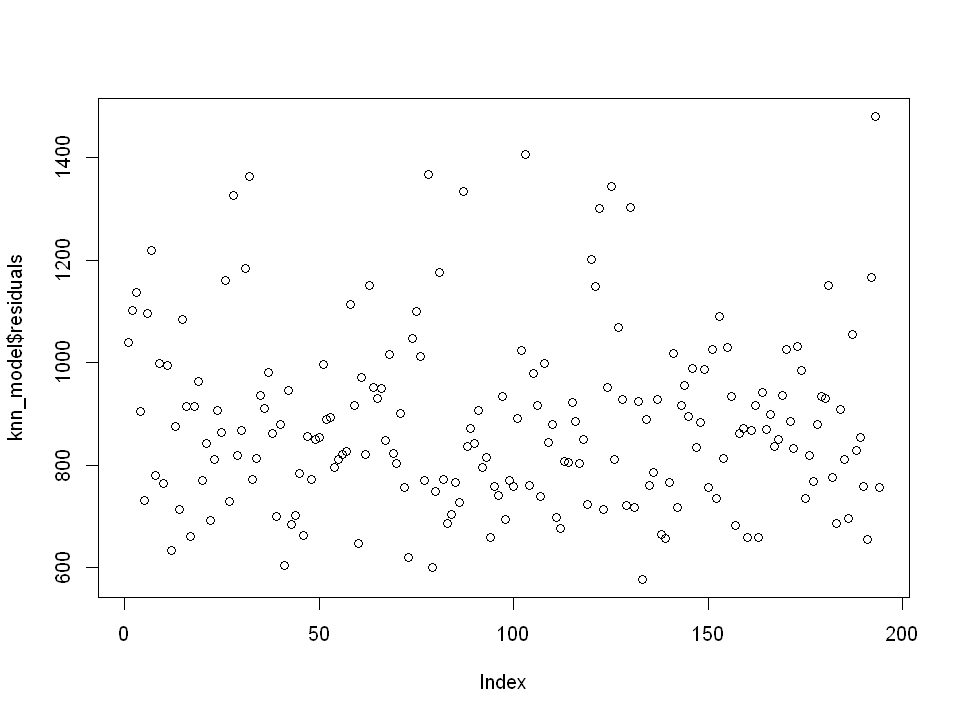

In [91]:
knn_model<-knn.reg(train=gym_train,test=gym_test,y=calories_burned_train,k=10)
mse_knn <- MSE(calories_burned_test,knn_model$pred)
R2_knn  <- R2(calories_burned_test,knn_model$pred)
paste("MSE: ",mse_knn ,sep="")
paste("R2: ",R2_knn ,sep="")
plot(knn_model$pred,knn_model$residuals)

# SVR

In [56]:

svm.reg = svm(calories_burned_train ~ ., data = gymr_train, cost = 1500, epsilon = 0.46, kernel = "linear")
summary(svm.reg)
fit.svr <- predict(svm.reg, newdata = gymr_test)
mse_svr <- MSE(calories_burned_test,fit.svr)
R2_svr  <- R2(calories_burned_test,fit.svr)
paste("MSE: ",mse_svr ,sep="")
paste("R2: ",R2_svr ,sep="")


Call:
svm(formula = calories_burned_train ~ ., data = gymr_train, cost = 1500, 
    epsilon = 0.46, kernel = "linear")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  1500 
      gamma:  0.05555556 
    epsilon:  0.46 


Number of Support Vectors:  16






[1] "MSE: 2667.14858797973"

[1] "R2: 0.960744548845812"

## Arbres

In [58]:
install.packages("rpart.plot")

Installation du package dans 'C:/Users/sliss/AppData/Local/R/win-library/4.3'
(car 'lib' n'est pas spécifié)



le package 'rpart.plot' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\sliss\AppData\Local\Temp\RtmpAX44ZH\downloaded_packages


Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


[1] "MSE: 4181.75123025981"

[1] "MSE apprentissage: 837.652122379035"

[1] "MSE: 4181.75123025981"

[1] "R2: 0.93845242372388"

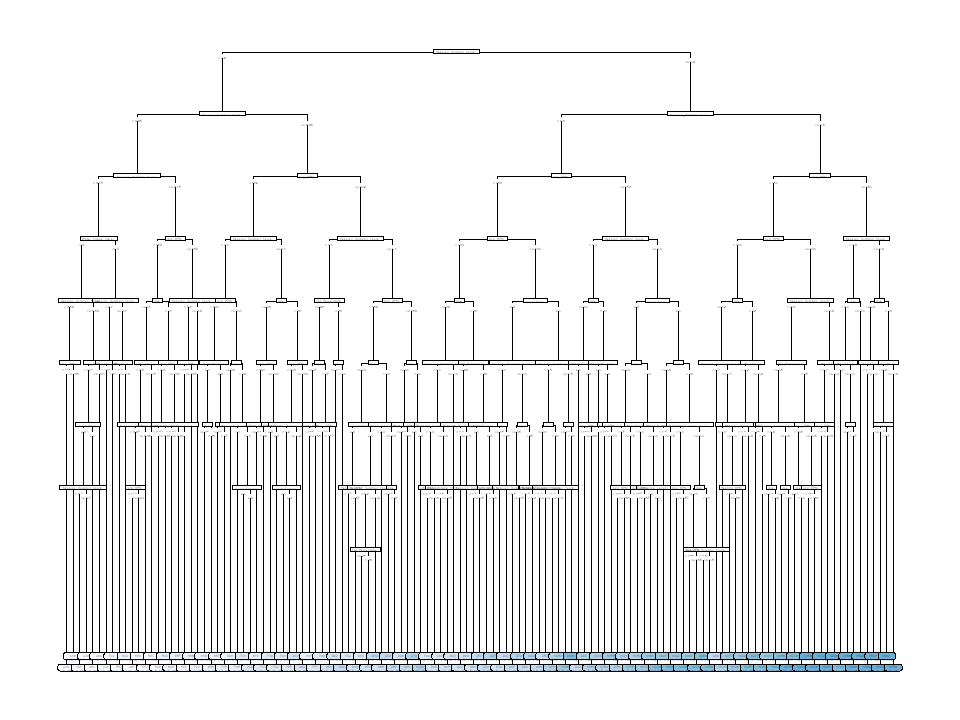

In [60]:
tree.reg=rpart(calories_burned_train~.,data=gym_train,control=rpart.control(maxdepth=9, minsplit = 3, minbucket = 3, cp = 0.0001))
rpart.plot(tree.reg,type=5,extra=101)
pred.treer=predict(tree.reg,newdata=gym_test)
mse_appr_treer <- mean((calories_burned_train - predict(tree.reg,newdata=gym_train))^2)
paste("MSE apprentissage: ",mse_appr_treer,sep="")

mse_treer <- MSE(calories_burned_test,pred.treer)
R2_treer <- R2(calories_burned_test,pred.treer)
paste("MSE: ",mse_treer ,sep="")
paste("R2: ",R2_treer ,sep="")

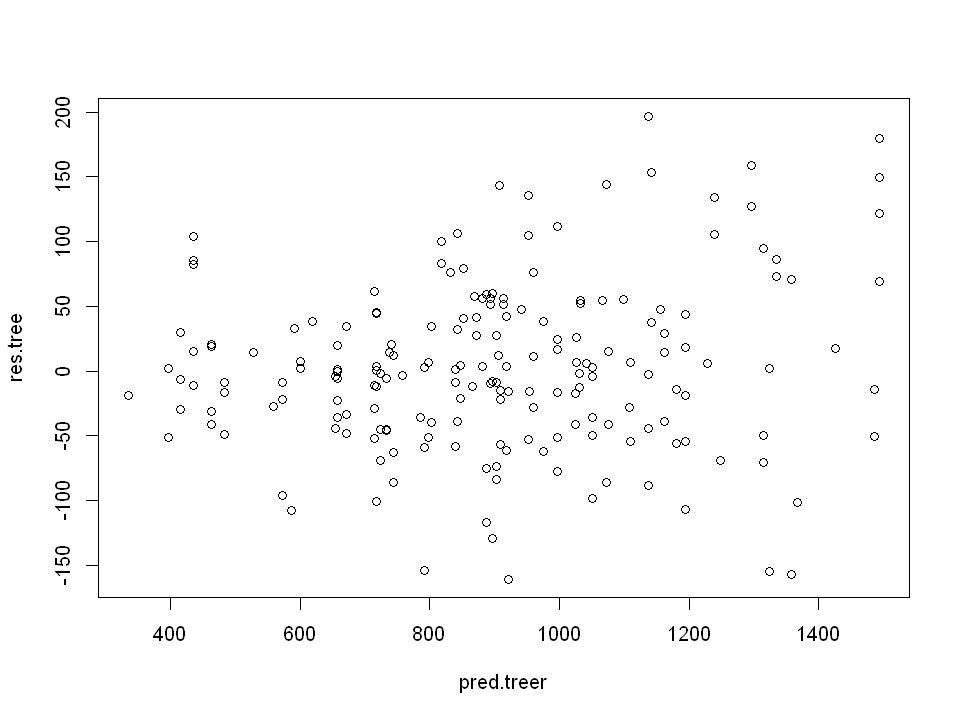

In [64]:
res.tree=pred.treer-calories_burned_test
plot(pred.treer,res.tree)

## RandomForest

In [68]:

rf.reg <- ranger(
  formula = calories_burned_train ~ ., 
  data = gym_train, 
  num.trees = 500,
  max.depth = 10,
    mtry = 14,
 min.node.size = 3,
    importance = "impurity"

)

In [69]:
#rf.reg=randomForest(calories_burned_train~., data=gym_train,
#   ntree=500,do.trace=50,importance=TRUE, mtry = 14, maxnodes = 10, nodesize = 2)
attributes(rf.reg)
rf.reg$mtry

$names
 [1] "predictions"               "num.trees"                
 [3] "num.independent.variables" "mtry"                     
 [5] "min.node.size"             "variable.importance"      
 [7] "prediction.error"          "forest"                   
 [9] "splitrule"                 "treetype"                 
[11] "r.squared"                 "call"                     
[13] "importance.mode"           "num.samples"              
[15] "replace"                   "dependent.variable.name"  
[17] "max.depth"                

$class
[1] "ranger"

[1] 14

In [70]:
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

[1]  465.3375 1177.8886 1241.4482  917.2721  962.1685 1139.9352

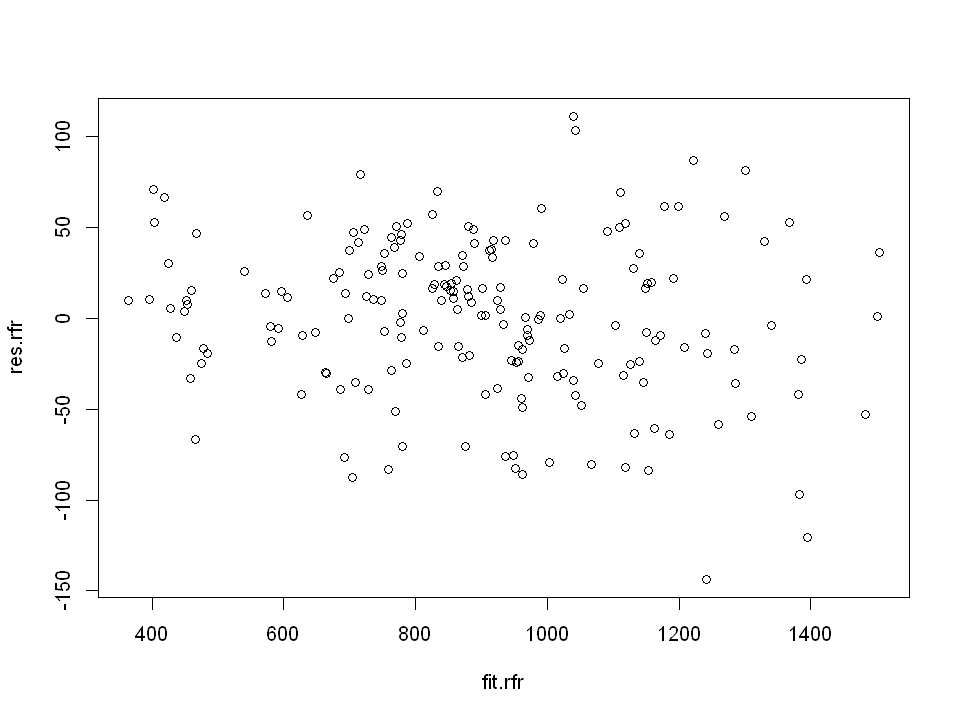

In [71]:
fit.rfr <- predict(rf.reg, data = gym_test)$predictions
res.rfr=fit.rfr-calories_burned_test
plot(fit.rfr,res.rfr)

In [72]:
rf.reg$variable.importance

GenderFemale                    GenderMale 
                    241033.10                     267897.94 
             Workout_TypeHIIT          Workout_TypeStrength 
                     26293.60                      30257.86 
             Workout_TypeYoga             Experience_Level2 
                     24636.45                     429995.85 
            Experience_Level3                           Age 
                   4098625.91                    1174091.28 
                   Height..m.                       Max_BPM 
                    237301.99                     153590.41 
                      Avg_BPM                   Resting_BPM 
                   6240704.41                     157778.79 
     Session_Duration..hours.                Fat_Percentage 
                  41833490.53                    3010161.56 
        Water_Intake..liters. Workout_Frequency..days.week. 
                    220416.51                     162062.98 
                 LWeight..kg.                          LBMI 
                    373585.51                     212805.66

In [73]:
varImpPlot(rf.reg)

ERROR: Error in varImpPlot(rf.reg): impossible de trouver la fonction "varImpPlot"


In [75]:
# Erreur quadratique moyenne de prévision
mse_appr_rf <- MSE(calories_burned_train, predict(rf.reg, data = gym_train)$predictions)
paste("MSE sur le jeu d'apprentissage : ", mse_appr_rf, sep = "")

mse_rfr <- MSE(calories_burned_test,fit.rfr)
R2_rfr <- R2(calories_burned_test,fit.rfr)
paste("MSE: ",mse_rfr ,sep="")
paste("R2: ",R2_rfr ,sep="")

[1] "MSE sur le jeu d'apprentissage : 284.471366880377"

[1] "MSE: 1839.48748744911"

[1] "R2: 0.972926176090176"

# Boosting

Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



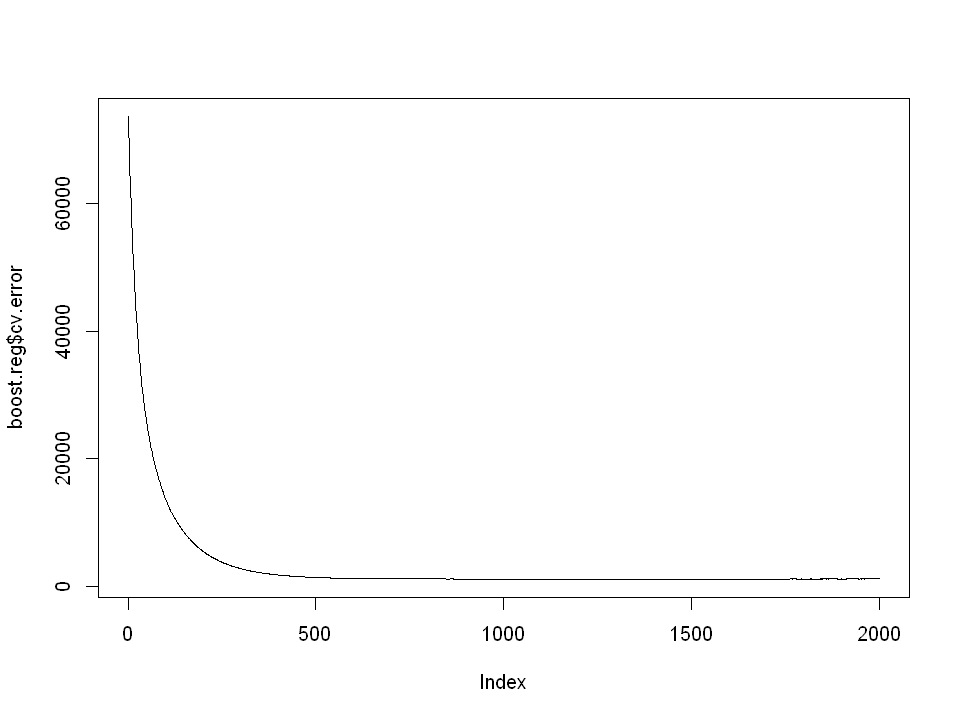

In [78]:
library(gbm)

boost.reg = gbm(calories_burned_train~.,data=gym_train, distribution = "gaussian", n.trees = 2000, 
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error, type = "l")

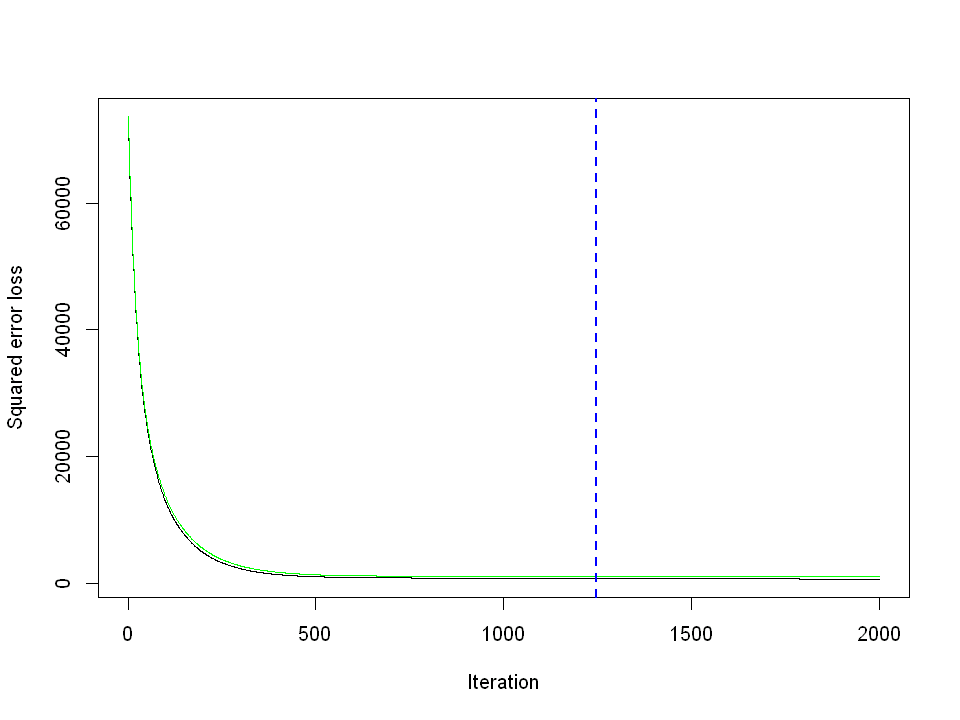

In [79]:
best.iter=gbm.perf(boost.reg,method="cv")

Warning message in pred.test - calories_burned_test:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in pred.test - calories_burned_test:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in pred.test - calories_burned_test:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in pred.test - calories_burned_test:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in pred.test - calories_burned_test:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in pred.test - calories_burned_test:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in pred.test - calories_burned_test:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in p

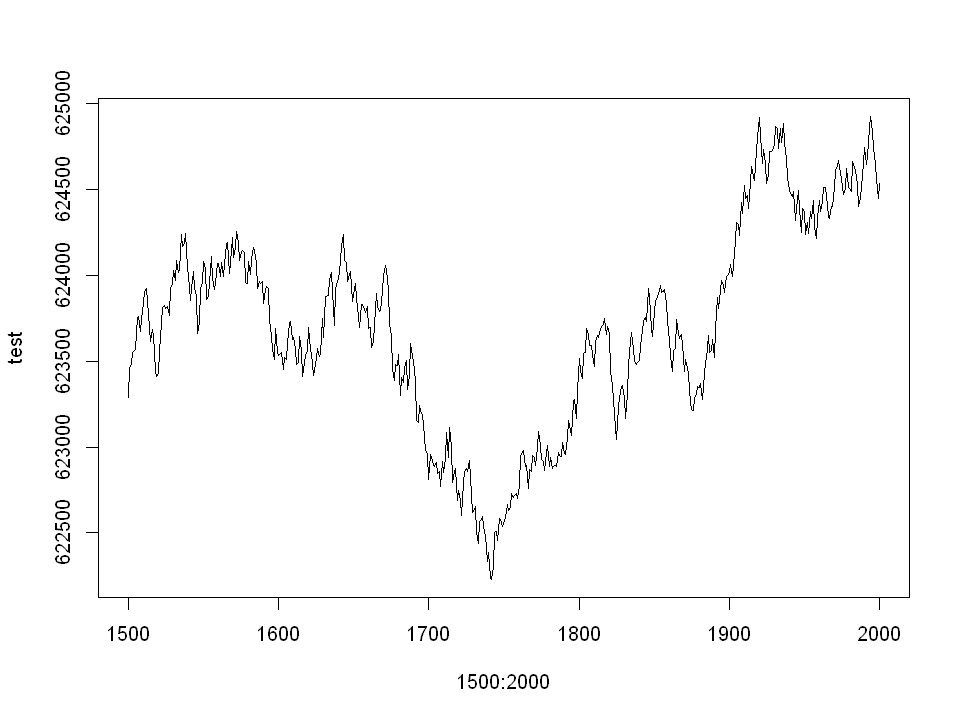

In [80]:
#tune n trees

test=numeric()
for (i in 1500:2000){
pred.test=predict(boost.reg,data=gym_test,n.trees=i)
err=sum((pred.test-calories_burned_test)^2)/nrow(gym_test)
test=c(test,err)}
plot(1500:2000,test,type="l")
abline(v=best.iter)


In [ ]:
test=numeric()
for (i in 10:500){
pred.test=predict(boost.reg,newdata=datestr,n.trees=i)
err=sum((pred.test-datestr[,"O3obs"])^2)/nrow(datestr)
test=c(test,err)}
plot(10:500,test,type="l")
abline(v=best.iter)

In [82]:
control <- trainControl(method = "cv", number = 5)


grid <- expand.grid(
  n.trees = 1800,           # n_estimators
  interaction.depth = c(2, 3, 5),        # max_depth
  shrinkage = c(0.02, 0.05, 0.1),        # learning_rate
  n.minobsinnode = 10                    # valeur fixe pour simplifier
)

gbm_model <- train(
  calories_burned_train~.,data=gym_train,
  method = "gbm",
  trControl = control,
  verbose = FALSE,
  tuneGrid = grid,
  bag.fraction = 0.8 
)

print(gbm_model$bestTune)

ERROR: Error in `[.data.frame`(data, , all.vars(Terms), drop = FALSE): colonnes non définies sélectionnées
